# Variational autoencoders

1. The output of the encoder is two vectors for each image:

    - One vector represents the mean.
    - The other represents the standard deviation.


2. From these two vectors, we fetch a modified vector that is the sum of the mean and standard deviation (which is multiplied by a random small number). The modified vector will be of the same number of dimensions as each vector.

3. The modified vector obtained in the previous step is passed as input to the decoder to fetch the image.

4. The loss value that we optimize for is a combination of the mean squared error and the KL divergence loss:
    - KL divergence loss measures the deviation of the distribution of the mean vector and the standard deviation vector from 0 and 1, respectively.
    - Mean squared loss is the optimization we use to re-construct (decode) an image.

In [11]:
from torch_snippets import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dataset = datasets.MNIST(root = '~/Data/mnist/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root = '~/Data/mnist/', train=False, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [12]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        self.d1 = nn.Linear(x_dim, h_dim1)
        self.d2 = nn.Linear(h_dim1, h_dim2)
        self.d31 = nn.Linear(h_dim2, z_dim)
        self.d32 = nn.Linear(h_dim2, z_dim)
        self.d4 = nn.Linear(z_dim, h_dim2)
        self.d5 = nn.Linear(h_dim2, h_dim1)
        self.d6 = nn.Linear(h_dim1, x_dim)
    def encoder(self, x):
        h = F.relu(self.d1(x))
        h = F.relu(self.d2(h))
        return self.d31(h), self.d32(h)
    def sampling(self, mean, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)
    def decoder(self, z):
        h = F.relu(self.d4(z))
        h = F.relu(self.d5(h))
        return F.sigmoid(self.d6(h))
    def forward(self, x):
        mean, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mean, log_var)
        return self.decoder(z), mean, log_var


In [13]:
def train_batch(data, model, optimizer, loss_function):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon_batch, data, mean, log_var)
    loss.backward()
    optimizer.step()
    return loss, mse, kld, log_var.mean(), mean.mean()

@torch.no_grad()
def validate_batch(data, model, loss_function):
    model.eval()
    data = data.to(device)
    recon, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon, data, mean, log_var)
    return loss, mse, kld, log_var.mean(), mean.mean()

In [14]:
def loss_function(recon_x, x, mean, log_var):
    RECON = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return RECON + KLD, RECON, KLD

In [15]:
vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=50).to(device)
optimizer = optim.AdamW(vae.parameters(), lr=1e-3)

EPOCH: 1.000  val_kld: 428.315  val_log_var: -0.243  train_recon: 2697.169  train_mean: -0.001  train_loss: 2946.071  val_recon: 1957.218  train_kld: 248.901  val_loss: 2385.532  val_mean: 0.003  train_log_var: -0.149  (3.18s - 28.63s remaining)


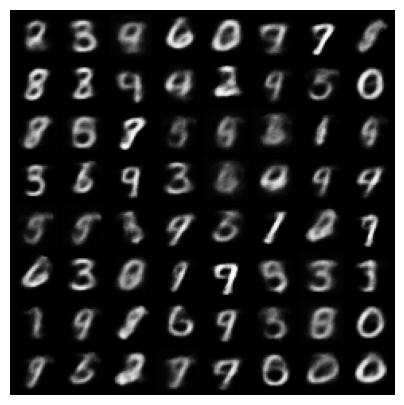

EPOCH: 2.000  val_kld: 521.166  val_log_var: -0.315  train_recon: 1741.429  train_mean: 0.001  train_loss: 2220.308  val_recon: 1595.071  train_kld: 478.879  val_loss: 2116.237  val_mean: 0.004  train_log_var: -0.290  (6.42s - 25.69s remaining)


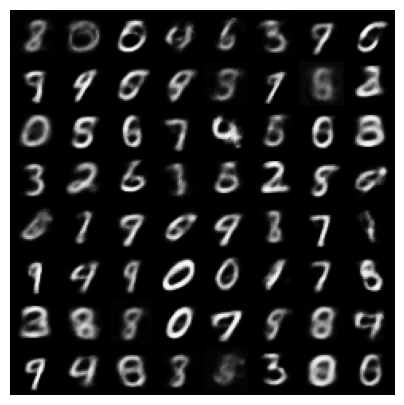

EPOCH: 3.000  val_kld: 531.340  val_log_var: -0.329  train_recon: 1547.934  train_mean: 0.000  train_loss: 2076.197  val_recon: 1496.765  train_kld: 528.262  val_loss: 2028.105  val_mean: 0.002  train_log_var: -0.325  (9.64s - 22.49s remaining)


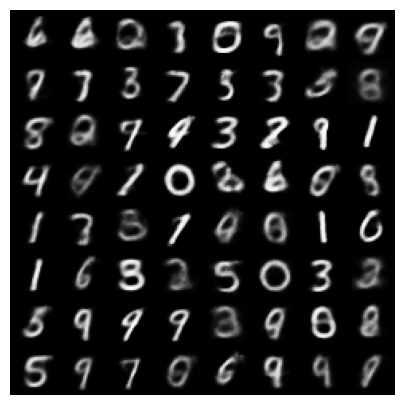

EPOCH: 4.000  val_kld: 583.342  val_log_var: -0.364  train_recon: 1456.515  train_mean: -0.000  train_loss: 2010.545  val_recon: 1384.896  train_kld: 554.030  val_loss: 1968.239  val_mean: -0.002  train_log_var: -0.343  (12.87s - 19.31s remaining)


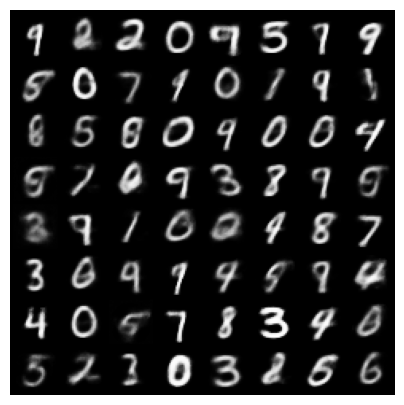

EPOCH: 5.000  val_kld: 576.231  val_log_var: -0.363  train_recon: 1401.591  train_mean: -0.001  train_loss: 1971.806  val_recon: 1366.640  train_kld: 570.215  val_loss: 1942.871  val_mean: 0.004  train_log_var: -0.354  (16.11s - 16.11s remaining)


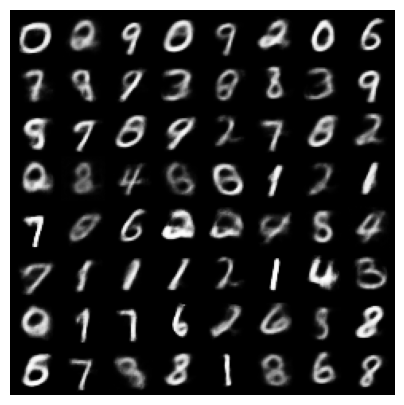

EPOCH: 6.000  val_kld: 563.958  val_log_var: -0.350  train_recon: 1353.608  train_mean: -0.001  train_loss: 1938.017  val_recon: 1345.350  train_kld: 584.408  val_loss: 1909.308  val_mean: -0.001  train_log_var: -0.363  (19.39s - 12.92s remaining)


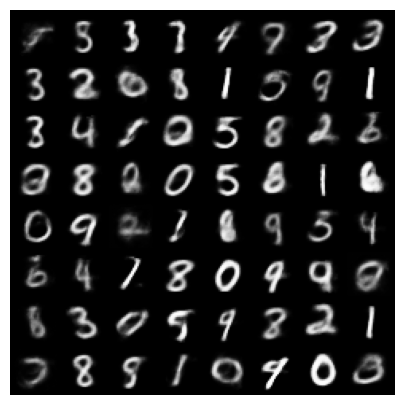

EPOCH: 7.000  val_kld: 574.958  val_log_var: -0.355  train_recon: 1315.385  train_mean: -0.001  train_loss: 1911.762  val_recon: 1312.494  train_kld: 596.377  val_loss: 1887.452  val_mean: -0.002  train_log_var: -0.371  (22.67s - 9.71s remaining)


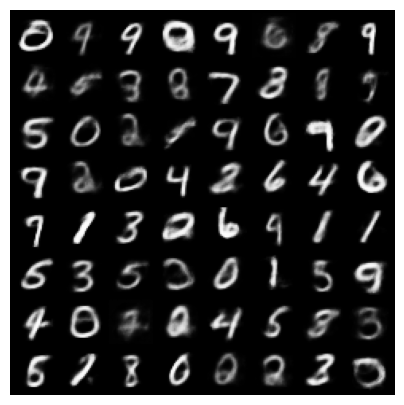

EPOCH: 8.000  val_kld: 587.145  val_log_var: -0.366  train_recon: 1285.160  train_mean: -0.001  train_loss: 1893.597  val_recon: 1279.447  train_kld: 608.437  val_loss: 1866.592  val_mean: -0.001  train_log_var: -0.379  (25.85s - 6.46s remaining)


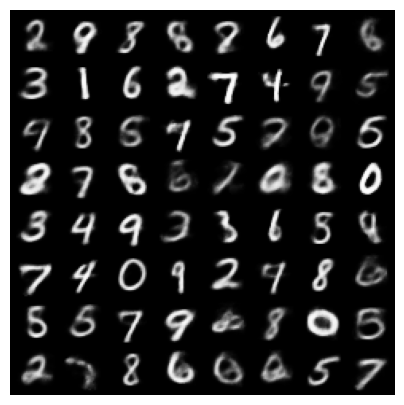

EPOCH: 9.000  val_kld: 620.753  val_log_var: -0.392  train_recon: 1260.396  train_mean: -0.001  train_loss: 1876.546  val_recon: 1245.055  train_kld: 616.150  val_loss: 1865.807  val_mean: 0.001  train_log_var: -0.384  (29.14s - 3.24s remaining)


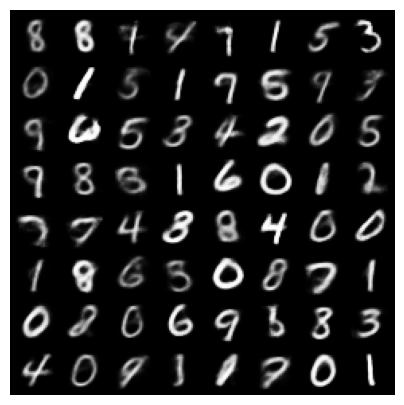

EPOCH: 10.000  val_kld: 627.444  val_log_var: -0.399  train_recon: 1240.060  train_mean: -0.001  train_loss: 1862.866  val_recon: 1218.679  train_kld: 622.806  val_loss: 1846.123  val_mean: -0.002  train_log_var: -0.388  (32.44s - 0.00s remaining)


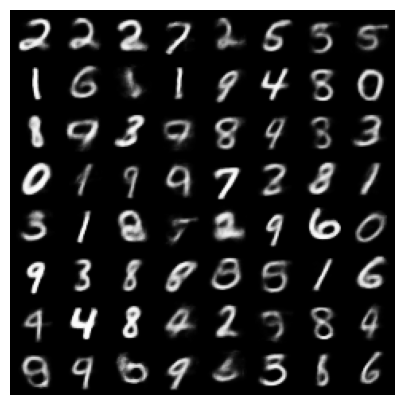

In [16]:
n_epochs = 10
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(train_loader)
    for batch_idx, (data, _) in enumerate(train_loader):
        loss, recon, kld, log_var, mean = train_batch(data, vae, optimizer, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, train_loss=loss, train_kld=kld, train_recon=recon, train_log_var=log_var, train_mean=mean, end='\r')
        
    N = len(test_loader)
    for batch_idx, (data, _) in enumerate(test_loader):
        loss, recon, kld, log_var, mean = validate_batch(data, vae, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, val_loss=loss, val_kld=kld, val_recon=recon, val_log_var=log_var, val_mean=mean, end='\r')
        
    log.report_avgs(epoch+1)
    with torch.no_grad():
        z = torch.randn(64, 50).to(device)
        sample = vae.decoder(z).to(device)
        images = make_grid(sample.view(64, 1, 28, 28)).permute(1,2,0)
        show(images)

100%|██████████| 111/111 [00:00<00:00, 1151.37it/s]


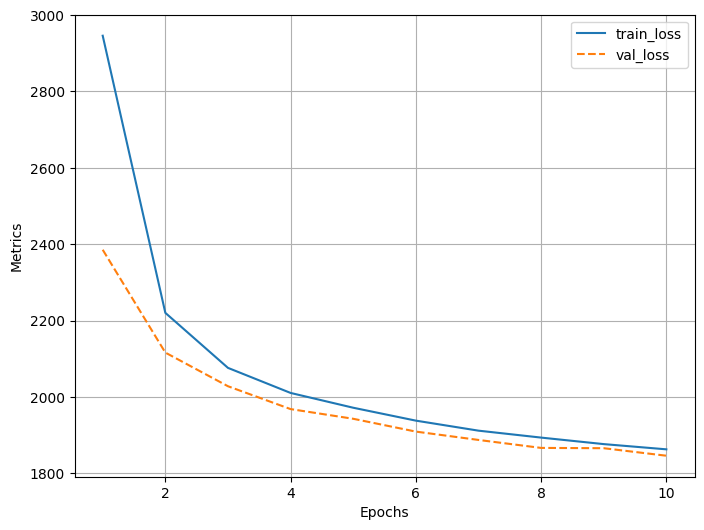

In [17]:
log.plot_epochs(['train_loss','val_loss'])